<a href="https://colab.research.google.com/github/code-with-ayesha/chatbots/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install gradio langchain langchain_groq langchain_core langchain_community tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00


In [2]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
TAVELI_API_KEY = userdata.get('TAVELI_API_KEY')

In [4]:
from typing import TypedDict

class ChatBotState(TypedDict):
    step: str
    user_input: str
    query_type: str  # Example values: "student_query" or "non_student_query"
    response: str


In [5]:
def receive_query(state: ChatBotState) -> ChatBotState:
    # Simulates user input captured through Gradio
    state["step"] = "check_query_type"
    return state

def check_query_type(state: ChatBotState) -> ChatBotState:
    if is_student_query(state["user_input"]):
        state["query_type"] = "student_query"
        state["step"] = "handle_student_query"
    else:
        state["query_type"] = "non_student_query"
        state["step"] = "handle_non_student_query"
    return state

def handle_student_query(state: ChatBotState) -> ChatBotState:
    try:
        prompt = f"You are a helpful assistant for students. Answer this question:\n{state['user_input']}"
        response = llm.invoke(prompt)
        state["response"] = response.content.strip()
        state["step"] = "end"
    except Exception as e:
        state["response"] = f"An error occurred: {str(e)}"
        state["step"] = "error_handling"
    return state

def handle_non_student_query(state: ChatBotState) -> ChatBotState:
    state["response"] = (
        "This chatbot is only for educational questions. Please ask something related to your studies or school."
    )
    state["step"] = "end"
    return state

def error_handling(state: ChatBotState) -> ChatBotState:
    # Handle any errors that occur during processing
    state["response"] = "An unexpected error occurred. Please try again."
    state["step"] = "end"
    return state


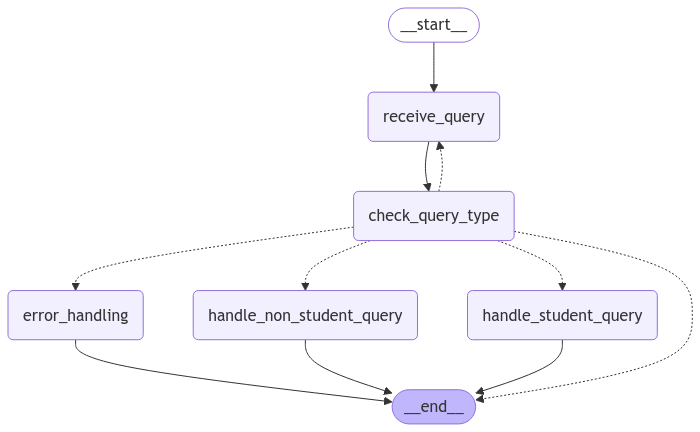

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Initialize the graph builder with the state schema
builder = StateGraph(state_schema=ChatBotState)

# Add nodes
builder.add_node("receive_query", receive_query)
builder.add_node("check_query_type", check_query_type)
builder.add_node("handle_student_query", handle_student_query)
builder.add_node("handle_non_student_query", handle_non_student_query)
builder.add_node("error_handling", error_handling)

# Define edges
builder.add_edge(START, "receive_query")
builder.add_edge("receive_query", "check_query_type")
builder.add_conditional_edges(
    "check_query_type", lambda state: state["step"]  # Transition to appropriate node
)
builder.add_edge("handle_student_query", END)
builder.add_edge("handle_non_student_query", END)
builder.add_edge("error_handling", END)

# Compile the graph
chatbot_graph = builder.compile()

# Visualize the graph
display(Image(chatbot_graph.get_graph().draw_mermaid_png()))


In [7]:
def chatbot_interface(user_input):
    # Initialize state
    state = ChatBotState(step="", user_input=user_input, query_type="", response="")

    # Start the workflow
    current_node = chatbot_graph.get_node(START)
    while current_node.id != END:
        state = current_node.function(state)
        current_node = chatbot_graph.get_node(state["step"])

    # Return the final response
    return state["response"]


In [8]:
import gradio as gr
from langchain_groq import ChatGroq
from google.colab import userdata


# Fetch your API key from userdata
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq model (e.g., "llama-3.1-70b-versatile")
llm = ChatGroq(model_name="llama-3.1-70b-versatile", temperature=1, api_key=groq_api_key)

# Function to check if the query is student-related
def is_student_query(query):
    # List of keywords related to student topics (you can extend this)
    student_keywords = ["homework", "study", "math", "science", "history", "assignment", "school", "exam","spelling","wiki"]
    return any(keyword.lower() in query.lower() for keyword in student_keywords)

# Function to handle student queries using Groq
def student_chatbot(student_input):
    try:
        # Check if the query is relevant to students
        if not is_student_query(student_input):
            return "This chatbot is only for educational questions. Please ask something related to your studies or school."

        # Modify the prompt to be more educational and relevant to the query
        prompt = f"You are a helpful assistant for students. Answer the following question in a way that helps a student understand the topic better:\n{student_input}"

        # Send the student's question to Groq's API and get a response
        response = llm.invoke(prompt)

        # Access the content directly from the response
        content = response.content  # Accessing content directly
        return content.strip()  # Return the content text

    except Exception as e:
        return f"An error occurred: {str(e)}"

# Gradio Interface
interface = gr.Interface(
    fn=student_chatbot,  # This is the function to call when input is provided
    inputs=gr.Textbox(label="Ask Your Question", placeholder="Enter your question here..."),
    outputs=gr.Textbox(label="Answer"),
    title="Student Helper Chatbot",  # Title of the Gradio app
    description="Ask me any educational question, and I'll help you learn!"  # Student-focused description
)

# Launch the app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2f3aa2cdbe52105531.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


workflow after binding the tools


In [9]:
from typing import TypedDict

class ChatBotState(TypedDict):
    user_input: str
    task: str  # The tool/task being used (e.g., "calculator", "wiki", etc.)
    response: str  # The chatbot's response


In [10]:
def receive_query(state: ChatBotState) -> ChatBotState:
    # This is the starting node where the chatbot receives the query
    state["task"] = "determine_task"
    return state

def determine_task(state: ChatBotState) -> ChatBotState:
    query = state["user_input"].lower()
    if any(char.isdigit() for char in query) and any(op in query for op in ["+", "-", "*", "/", "^"]):
        state["task"] = "calculator"
    elif "wiki" in query or "information about" in query:
        state["task"] = "wikipedia"
    elif "check spelling" in query:
        state["task"] = "spell_checker"
    elif "search taveli" in query:
        state["task"] = "taveli_search"
    else:
        state["task"] = "groq"
    return state

def calculator_task(state: ChatBotState) -> ChatBotState:
    state["response"] = f"Calculator Result: {calculate_expression(state['user_input'])}"
    return state

def wikipedia_task(state: ChatBotState) -> ChatBotState:
    query = state["user_input"].replace("wiki", "").replace("information about", "").strip()
    state["response"] = f"Wikipedia Result: {search_wikipedia(query)}"
    return state

def spell_checker_task(state: ChatBotState) -> ChatBotState:
    query = state["user_input"].replace("check spelling", "").strip()
    state["response"] = f"Corrected Spelling: {check_spelling(query)}"
    return state

def taveli_task(state: ChatBotState) -> ChatBotState:
    query = state["user_input"].replace("search taveli", "").strip()
    state["response"] = f"Taveli Result: {search_taveli(query)}"  # Assuming a function `search_taveli`
    return state

def groq_task(state: ChatBotState) -> ChatBotState:
    prompt = f"You are a helpful assistant for students. Answer this question:\n{state['user_input']}"
    response = llm.invoke(prompt)
    state["response"] = response.content.strip()
    return state

def error_task(state: ChatBotState) -> ChatBotState:
    state["response"] = "An error occurred. Please try again."
    return state


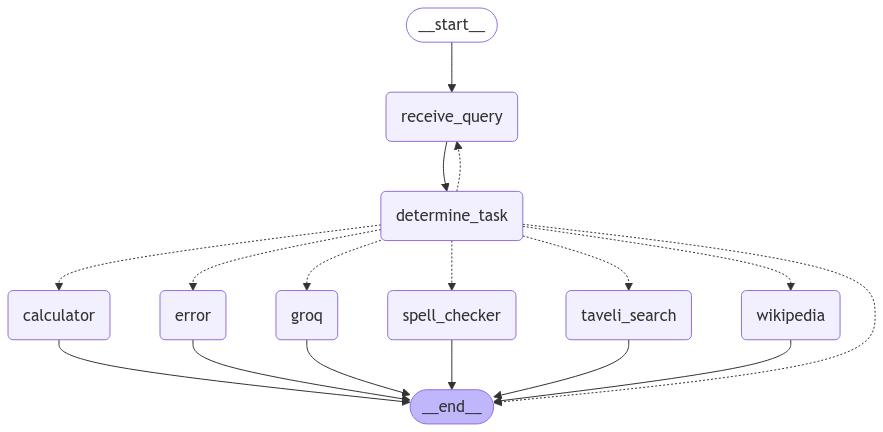

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Initialize the graph builder with the state schema
builder = StateGraph(state_schema=ChatBotState)

# Add nodes
builder.add_node("receive_query", receive_query)
builder.add_node("determine_task", determine_task)
builder.add_node("calculator", calculator_task)
builder.add_node("wikipedia", wikipedia_task)
builder.add_node("spell_checker", spell_checker_task)
builder.add_node("taveli_search", taveli_task)
builder.add_node("groq", groq_task)
builder.add_node("error", error_task)

# Define edges
builder.add_edge(START, "receive_query")
builder.add_edge("receive_query", "determine_task")
builder.add_conditional_edges(
    "determine_task",
    lambda state: state["task"],  # Route based on the task identified
)
builder.add_edge("calculator", END)
builder.add_edge("wikipedia", END)
builder.add_edge("spell_checker", END)
builder.add_edge("taveli_search", END)
builder.add_edge("groq", END)
builder.add_edge("error", END)

# Compile the graph
chatbot_graph = builder.compile()

# Visualize the graph
display(Image(chatbot_graph.get_graph().draw_mermaid_png()))


In [12]:
!pip -q install wikipedia

  Preparing metadata (setup.py) ... done


In [13]:
!pip -q install wikipedia-api


  Preparing metadata (setup.py) ... done


In [14]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.1 MB/s eta 0:00:00


In [15]:
import os
os.environ["TAVELI_API_KEY"] = userdata.get('TAVELI_API_KEY')

In [16]:
# Instead of:
# from langgraph_sdk import StateGraph

# Use:
from langgraph.graph import StateGraph # Import StateGraph from langgraph.graph

In [19]:
import gradio as gr
from langchain_groq import ChatGroq
from google.colab import userdata
import wikipedia
import sympy as sp
from spellchecker import SpellChecker
import re

# Fetch your API keys from userdata
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq model
llm = ChatGroq(model_name="llama-3.1-70b-versatile", temperature=1, api_key=groq_api_key)

# Initialize the spell checker
spell = SpellChecker()

# Tool 1: Spell Checker
def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

# Tool 2: Wikipedia Search
def search_wikipedia(query):
    try:
        # Search Wikipedia for a summary of the query
        summary = wikipedia.summary(query, sentences=3)
        return summary
    except wikipedia.exceptions.DisambiguationError as e:
        options = ", ".join(e.options[:5])  # Suggest up to 5 options
        return f"The query '{query}' is ambiguous. Did you mean one of the following? {options}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'. Please try another search term."
    except Exception as e:
        return f"Could not find relevant information: {str(e)}"

# Tool 3: Calculator
def calculate_expression(expression):
    try:
        # Validate mathematical expression using a regex
        math_expression = re.fullmatch(r"[\d\.\+\-\*/\^\(\)\s]+", expression)
        if not math_expression:
            return "Error: Invalid mathematical syntax in the input."

        # Safely evaluate the mathematical expression using sympy
        result = sp.sympify(math_expression.group())
        return str(result)  # Return the calculated result as a string
    except sp.SympifyError:
        return "Error: Invalid mathematical expression."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

# Function to check if the query is educational
def is_educational_query(query):
    # List of words related to jokes or entertainment
    non_educational_keywords = ['joke', 'funny', 'humor', 'meme', 'laugh']

    # Check if the query contains any non-educational keywords
    for word in non_educational_keywords:
        if word.lower() in query.lower():
            return False
    return True

# Function to process the input query
def process_query(student_input):
    try:
        # Reject non-educational queries
        if not is_educational_query(student_input):
            return "This chatbot is designed for educational purposes only. Please ask an educational question."

        # Detect if the query is a calculation
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Detect if the query is a Wikipedia search
        if "wiki" in student_input.lower() or "information about" in student_input.lower():
            query = student_input.replace("wiki", "").replace("information about", "").strip()
            return f"Wikipedia Result: {search_wikipedia(query)}"

        # Detect if spelling corrections are needed
        if "check spelling" in student_input.lower():
            query = student_input.replace("check spelling", "").strip()
            return f"Corrected Spelling: {check_spelling(query)}"

        # Default: Use the Groq model for student questions
        prompt = f"You are a helpful assistant for students. Answer the following question in a way that helps a student understand the topic better:\n{student_input}"
        response = llm.invoke(prompt)
        return response.content.strip()
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Gradio Interface
interface = gr.Interface(
    fn=process_query,
    inputs=gr.Textbox(label="Ask Your Question", placeholder="Enter your question here..."),
    outputs=gr.Textbox(label="Answer"),
    title="Student Helper Chatbot",
    description=(
        "Ask me any educational question, and I'll help you learn! Features include:\n"
        "- Math calculations (e.g., 2+3*4).\n"
        "- Wikipedia search (e.g., 'wiki [topic]').\n"
        "- Spell checking (e.g., 'check spelling accomodate')."
    )
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a46d3166632b17f57b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp
import re

# Tools: Spell Checker, Wikipedia Search, Calculator
spell = SpellChecker()

def check_spelling(text):
    """Corrects spelling mistakes in the given text."""
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    """Searches Wikipedia and returns the summary."""
    try:
        summary = wikipedia.summary(query, sentences=2)
        return summary
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Did you mean: {', '.join(e.options[:5])}?"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error: {e}"

def calculate_expression(expression):
    """Evaluates mathematical expressions."""
    try:
        result = sp.sympify(expression)
        return str(result)
    except Exception as e:
        return f"Error in calculation: {e}"

# Workflow Management: Human-in-the-Loop
def chatbot_with_hitl(user_input, human_feedback=None, interrupt=False):
    """Chatbot logic with human-in-the-loop feedback."""
    # Determine which tool to use based on input keywords
    if "spell" in user_input.lower():
        tool_output = check_spelling(user_input)
        task = "spell checker"
    elif "wiki" in user_input.lower():
        query = user_input.replace("wiki", "").strip()
        tool_output = search_wikipedia(query)
        task = "Wikipedia search"
    elif any(op in user_input for op in "+-*/"):
        tool_output = calculate_expression(user_input)
        task = "calculator"
    else:
        return "I didn't understand your request. Please specify 'spell', 'wiki', or a math operation."

    # If interrupt is True, display the intermediate state
    if interrupt:
        return {
            "task": task,
            "tool_output": tool_output,
            "feedback_prompt": "Do you want to modify the output or approve it?",
        }

    # If human feedback is provided, update the output or proceed
    if human_feedback:
        tool_output = human_feedback  # Use the human-corrected output

    # Final response
    return f"Task: {task}\nResult: {tool_output}"

# Gradio Interface
def gradio_interface(user_input, interrupt=False, human_feedback=""):
    """Wrapper for the Gradio interface to manage HITL."""
    result = chatbot_with_hitl(user_input, human_feedback, interrupt)
    if isinstance(result, dict):  # When interrupt=True, show intermediate state
        return (
            f"Task: {result['task']}\nTool Output: {result['tool_output']}",
            result["feedback_prompt"],
        )
    else:  # Final output
        return (result, "No feedback needed.")

# Gradio Layout
with gr.Blocks() as interface:
    gr.Markdown("## Student Chatbot with Human-in-the-Loop")
    with gr.Row():
        user_input = gr.Textbox(label="Your Input", placeholder="Enter your question...")
        interrupt = gr.Checkbox(label="Interrupt for Feedback", value=False)
    tool_output = gr.Textbox(label="Tool Output", interactive=False)
    feedback = gr.Textbox(label="Your Feedback (if any)")
    submit = gr.Button("Submit")

    submit.click(
        gradio_interface,
        inputs=[user_input, interrupt, feedback],
        outputs=[tool_output, feedback],
    )

# Launch Gradio Interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a07f23cf4595bd418b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
import gradio as gr
import wikipedia
import sympy as sp
from spellchecker import SpellChecker
from langchain_groq import ChatGroq

# Initialize Groq model
llm = ChatGroq(model_name="llama-3.1-70b-versatile", temperature=1, api_key="your-api-key")

# Initialize tools
spell = SpellChecker()

# Define tools
def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except Exception as e:
        return str(e)

def calculate_expression(expression):
    try:
        result = sp.sympify(expression)
        return str(result)
    except Exception:
        return "Invalid mathematical expression."

# Define chatbot logic
state = {"messages": []}  # State to keep track of interactions

def chatbot(input_text, feedback=None):
    global state
    if feedback:  # If feedback is provided, update state
        state["messages"].append({"role": "user", "content": feedback})
        state["messages"].append({"role": "system", "content": "Your feedback has been processed. Let me refine my response."})

    # Process input based on type
    if "calculate" in input_text.lower():
        expression = input_text.replace("calculate", "").strip()
        answer = calculate_expression(expression)
    elif "spell" in input_text.lower():
        text = input_text.replace("spell", "").strip()
        answer = check_spelling(text)
    elif "wiki" in input_text.lower():
        query = input_text.replace("wiki", "").strip()
        answer = search_wikipedia(query)
    else:
        # Default to LLM if not a tool-related input
        response = llm.invoke(input_text)
        answer = response.content.strip()

    # Save input and answer to state
    state["messages"].append({"role": "user", "content": input_text})
    state["messages"].append({"role": "assistant", "content": answer})
    return answer

# Gradio interface
with gr.Blocks() as interface:
    gr.Markdown("# Student Helper Chatbot with Feedback")

    with gr.Row():
        input_text = gr.Textbox(label="Your Question", placeholder="Ask me something...")
        feedback_text = gr.Textbox(label="Provide Feedback (Optional)", placeholder="Provide corrections or additional context...")

    response_text = gr.Textbox(label="Chatbot Response", interactive=False)

    submit_button = gr.Button("Submit")

    submit_button.click(chatbot, inputs=[input_text, feedback_text], outputs=[response_text])

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eb0536d2d60222520e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
import gradio as gr
import sympy as sp
from spellchecker import SpellChecker
import wikipedia
from langchain_groq import ChatGroq

# Initialize tools
spell = SpellChecker()
llm = ChatGroq(model_name="llama-3.1-70b-versatile", temperature=1, api_key="your-api-key")

# State to track inputs and responses
state = {"last_input": None, "last_response": None}

# Tool functions
def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Did you mean: {', '.join(e.options[:5])}?"
    except wikipedia.exceptions.PageError:
        return "No matching page found."
    except Exception as e:
        return str(e)

def calculate_expression(expression):
    try:
        result = sp.sympify(expression)
        return str(result)
    except Exception:
        return "Invalid mathematical expression."

# Chatbot logic
def chatbot(input_text, feedback=None):
    global state

    # Handle feedback
    if feedback:
        state["last_input"] = feedback  # Replace the last input with feedback
        input_text = feedback

    # Process input
    if "calculate" in input_text.lower():
        expression = input_text.replace("calculate", "").strip()
        answer = calculate_expression(expression)
    elif "spell" in input_text.lower():
        text = input_text.replace("spell", "").strip()
        answer = check_spelling(text)
    elif "wiki" in input_text.lower():
        query = input_text.replace("wiki", "").strip()
        answer = search_wikipedia(query)
    else:
        # Default to LLM
        response = llm.invoke(input_text)
        answer = response.content.strip()

    # Save to state
    state["last_input"] = input_text
    state["last_response"] = answer

    return answer

# Gradio Interface
with gr.Blocks() as interface:
    gr.Markdown("# Student Helper Chatbot with Feedback Handling")

    with gr.Row():
        input_text = gr.Textbox(label="Your Question", placeholder="Enter your question here...")
        feedback_text = gr.Textbox(label="Feedback (Optional)", placeholder="Provide feedback or corrections...")

    response_text = gr.Textbox(label="Chatbot Response", interactive=False)
    submit_button = gr.Button("Submit")

    # Define the submit button click behavior
    submit_button.click(chatbot, inputs=[input_text, feedback_text], outputs=[response_text])

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://85b36183823cb12a7f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [24]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import re
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        math_expression = re.search(r"[\d\.\+\-\*/\^\(\)]+", expression)
        if math_expression:
            result = sp.sympify(math_expression.group())
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback
last_tool_used = {"tool": None, "input": None}

# Chatbot logic
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing
    try:
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    )
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cceeed6c46cb7145fe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import re
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Match a valid mathematical expression
        math_expression = re.search(r"[\d\.\+\-\*/\^\(\)]+", expression)
        if math_expression:
            result = sp.sympify(math_expression.group())  # Safely evaluate the expression
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a655160216a9976e2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [27]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import re
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Match a valid mathematical expression
        math_expression = re.search(r"[\d\.\+\-\*/\^\(\)]+", expression)
        if math_expression:
            result = sp.sympify(math_expression.group())  # Safely evaluate the expression
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86accd33f97b93ede0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [28]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Parse the math expression directly using sympy
        result = sp.sympify(expression)  # sympy handles math expressions directly
        return str(result)
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad9a37d397964432ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Ensure only valid mathematical expressions are parsed
        if any(op in expression for op in ["+", "-", "*", "/", "^"]):
            result = sp.sympify(expression)  # sympy handles math expressions directly
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool only if it's a valid math expression
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation (contains digits and mathematical operators)
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8affaeae7a43b6bfc6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [30]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Ensure only valid mathematical expressions are parsed
        if any(op in expression for op in ["+", "-", "*", "/", "^"]):
            result = sp.sympify(expression)  # sympy handles math expressions directly
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool only if it's a valid math expression
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation (contains digits and mathematical operators)
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://59fd44fc39c220c679.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


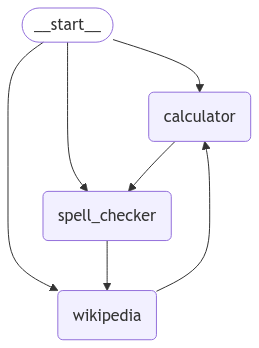

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d780116205d76878f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Ensure only valid mathematical expressions are parsed
        if any(op in expression for op in ["+", "-", "*", "/", "^"]):
            result = sp.sympify(expression)  # sympy handles math expressions directly
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        print(f"Received feedback: {feedback}")  # Debugging print statement
        print(f"Last tool used: {last_tool_used['tool']}")  # Debugging print statement

        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool only if it's a valid math expression
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation (contains digits and mathematical operators)
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            print(f"Using calculator for input: {student_input}")  # Debugging print statement
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            print(f"Using spell checker for input: {query}")  # Debugging print statement
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            print(f"Using Wikipedia for input: {query}")  # Debugging print statement
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# State graph creation
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("calculator", lambda state: {"messages": [calculate_expression(state['messages'][0]["content"])]})
builder.add_node("spell_checker", lambda state: {"messages": [check_spelling(state['messages'][0]["content"])]})
builder.add_node("wikipedia", lambda state: {"messages": [search_wikipedia(state['messages'][0]["content"])]})

# Define edges
builder.add_edge(START, "calculator")
builder.add_edge(START, "spell_checker")
builder.add_edge(START, "wikipedia")

builder.add_edge("calculator", "spell_checker")
builder.add_edge("spell_checker", "wikipedia")
builder.add_edge("wikipedia", "calculator")

# Graph for state transitions
graph = builder.compile()

# Visualizing the graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


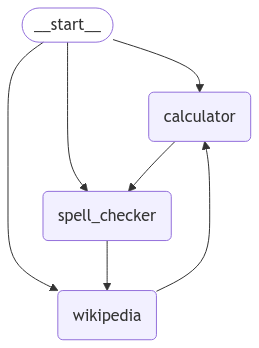

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://978e677075440ca0de.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize tools
spell = SpellChecker()

def calculate_expression(expression):
    try:
        # Ensure only valid mathematical expressions are parsed
        if any(op in expression for op in ["+", "-", "*", "/", "^"]):
            result = sp.sympify(expression)  # sympy handles math expressions directly
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# State for tracking feedback and previous tool usage
last_tool_used = {"tool": None, "input": None}

# Chatbot logic to handle feedback and different tools
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        print(f"Received feedback: {feedback}")  # Debugging print statement
        print(f"Last tool used: {last_tool_used['tool']}")  # Debugging print statement

        if last_tool_used["tool"] == "calculator":
            # Reprocess the feedback through the calculator tool only if it's a valid math expression
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            # Reprocess the feedback through the spell checker tool
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            # Reprocess the feedback through the Wikipedia tool
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        # Check if input is a valid calculation (contains digits and mathematical operators)
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            last_tool_used["input"] = student_input
            print(f"Using calculator for input: {student_input}")  # Debugging print statement
            return f"Calculator Result: {calculate_expression(student_input)}"

        # Check if the input is a spell checking request
        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            last_tool_used["input"] = query
            print(f"Using spell checker for input: {query}")  # Debugging print statement
            return f"Corrected Spelling: {check_spelling(query)}"

        # Check if the input is a Wikipedia query
        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            last_tool_used["input"] = query
            print(f"Using Wikipedia for input: {query}")  # Debugging print statement
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# State graph creation
builder = StateGraph(MessagesState)

# Define nodes (tools and their feedback)
builder.add_node("calculator", lambda state: {"messages": [calculate_expression(state['messages'][0]["content"])]})
builder.add_node("spell_checker", lambda state: {"messages": [check_spelling(state['messages'][0]["content"])]})
builder.add_node("wikipedia", lambda state: {"messages": [search_wikipedia(state['messages'][0]["content"])]})

# Define edges (tool transitions, including feedback processing)
builder.add_edge(START, "calculator")
builder.add_edge(START, "spell_checker")
builder.add_edge(START, "wikipedia")

builder.add_edge("calculator", "spell_checker")
builder.add_edge("spell_checker", "wikipedia")
builder.add_edge("wikipedia", "calculator")

# Graph for state transitions
graph = builder.compile()

# Visualizing the graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Gradio Interface with updated feedback handling
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True  # Enable live feedback to immediately process changes
)

# Launch the interface
interface.launch()


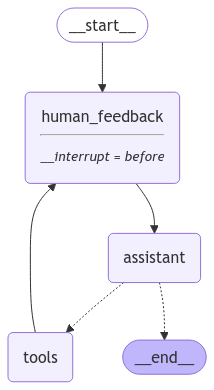

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ebafcad26b52430665.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [34]:
import gradio as gr
from spellchecker import SpellChecker
import wikipedia
import sympy as sp
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize tools
spell = SpellChecker()

# Define the tools
def calculate_expression(expression):
    try:
        # Ensure only valid mathematical expressions are parsed
        if any(op in expression for op in ["+", "-", "*", "/", "^"]):
            result = sp.sympify(expression)  # sympy handles math expressions directly
            return str(result)
        else:
            return "No valid mathematical expression found."
    except Exception as e:
        return f"Error in calculation: {str(e)}"

def check_spelling(text):
    corrected_words = [spell.correction(word) for word in text.split()]
    return " ".join(corrected_words)

def search_wikipedia(query):
    try:
        return wikipedia.summary(query, sentences=3)
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Ambiguous query. Options: {', '.join(e.options[:5])}"
    except wikipedia.exceptions.PageError:
        return f"No page found for '{query}'."
    except Exception as e:
        return f"Error in Wikipedia search: {str(e)}"

# Define a system message for the assistant
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Define the feedback node (currently a no-op, can be extended to process feedback)
def human_feedback(state: MessagesState):
    pass  # Placeholder for handling human feedback

# Assistant node that processes input
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# ToolNode to invoke specific tools based on state
def tools(state: MessagesState):
    message = state["messages"][0]["content"]

    if any(char.isdigit() for char in message) and any(op in message for op in ["+", "-", "*", "/", "^"]):
        return {"messages": [calculate_expression(message)]}
    elif "spell" in message.lower():
        query = message.replace("spell", "").strip()
        return {"messages": [check_spelling(query)]}
    elif "wiki" in message.lower():
        query = message.replace("wiki", "").strip()
        return {"messages": [search_wikipedia(query)]}

    return {"messages": ["This chatbot is for educational purposes only."]}

# Create the state graph builder
builder = StateGraph(MessagesState)

# Add nodes for the assistant, tools, and feedback
builder.add_node("assistant", assistant)
builder.add_node("tools", tools)
builder.add_node("human_feedback", human_feedback)

# Add edges for transitions: start -> feedback -> assistant -> tools -> feedback
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message is a tool call, route to the tools node
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

# Memory saver to store the state
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Display the graph as a Mermaid diagram
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# Gradio Interface with updated feedback handling
def student_chatbot(student_input, feedback=None):
    global last_tool_used

    # Handle feedback, processing based on the tool previously used
    if feedback:
        print(f"Received feedback: {feedback}")  # Debugging print statement
        print(f"Last tool used: {last_tool_used['tool']}")  # Debugging print statement

        if last_tool_used["tool"] == "calculator":
            return f"Calculator Feedback Result: {calculate_expression(feedback)}"
        elif last_tool_used["tool"] == "spell_checker":
            return f"Spell Checker Feedback Result: {check_spelling(feedback)}"
        elif last_tool_used["tool"] == "wikipedia":
            return f"Wikipedia Feedback Result: {search_wikipedia(feedback)}"
        else:
            return "No previous tool used. Feedback cannot be processed."

    # Regular processing based on the student's input
    try:
        if any(char.isdigit() for char in student_input) and any(op in student_input for op in ["+", "-", "*", "/", "^"]):
            last_tool_used["tool"] = "calculator"
            return f"Calculator Result: {calculate_expression(student_input)}"

        if "spell" in student_input.lower():
            query = student_input.replace("spell", "").strip()
            last_tool_used["tool"] = "spell_checker"
            return f"Corrected Spelling: {check_spelling(query)}"

        if "wiki" in student_input.lower():
            query = student_input.replace("wiki", "").strip()
            last_tool_used["tool"] = "wikipedia"
            return f"Wikipedia Result: {search_wikipedia(query)}"

        return "This chatbot is for educational purposes only."

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface
interface = gr.Interface(
    fn=student_chatbot,
    inputs=[
        gr.Textbox(label="Your Question", placeholder="Enter your question here..."),
        gr.Textbox(label="Provide Feedback (optional)", placeholder="Enter feedback here...")
    ],
    outputs=gr.Textbox(label="Response"),
    title="Student Helper Chatbot with Feedback",
    description=(
        "Ask educational questions related to:\n"
        "- Calculations (e.g., 2 + 2).\n"
        "- Spell Checking (e.g., 'spell accomodate').\n"
        "- Wikipedia Search (e.g., 'wiki Python programming').\n\n"
        "You can also provide feedback for corrections in the Feedback box."
    ),
    live=True
)

# Launch the Gradio interface
interface.launch()
